# Processing Activity Data for TRPM8

This notebook uses the activity data for Homo Sapiens TRPM8 found on Chembl: https://www.ebi.ac.uk/chembl/web_components/explore/activities/STATE_ID:QcxDH17OZ95LqHehOkjCEg%3D%3D 

The steps are as follows:
* Remove empty activity values, salt ions, and small fragments
* Ensure SMILE representation is correct
* Remove Duplicates
* Standardize IC50 Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, SaltRemover
from rdkit import RDLogger
from sklearn.preprocessing import StandardScaler

RDLogger.DisableLog('rdApp.warning')  # Disables only warning messages

### Read `.csv` File Containing Activity Information

The documentation on the columns can be found here: https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/releases/chembl_34/schema_documentation.html

In [2]:
#Read the CSV file
file_path = 'TRPM8-homosapien-compounds-activities.csv'
df = pd.read_csv(file_path, delimiter=';', skipinitialspace=True)

#Drop columns we won't need
df.drop(['Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Comment',
         'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Uo Units',
         'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID',
         'Standard Text Value', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Assay ChEMBL ID',
         'Cell ChEMBL ID','Properties', 'Molecule Name', 'Molecule Max Phase','Standard Relation','Potential Duplicate'],
          axis=1, inplace=True)

print("Original dataset size:", df.shape[0],"entries")
df.head()

Original dataset size: 1168 entries


,Molecule ChEMBL ID,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Action Type
0,CHEMBL3235962,421.42,1.0,5.76,22,N#Cc1cccc(NC(=O)N2CCc3ccccc3[C@H]2c2ccc(C(F)(F...,IC50,83.000,nM,7.08,NaN,16.80,0.31,1.32,12.62,NaN
1,CHEMBL3235983,434.36,1.0,5.45,44,C[C@H](NC(=O)N1CCc2ccccc2[C@H]1c1ccc(C(F)(F)F)...,IC50,10.000,nM,8.00,NaN,18.42,0.36,2.55,24.74,NaN
2,CHEMBL1650511,467.41,1.0,7.09,5,FC(F)(F)c1ccccc1-c1cc(C(F)(F)F)c2[nH]c(C3=NOC4...,IC50,0.413,nM,9.38,NaN,20.08,0.39,2.29,18.67,NaN
3,CHEMBL2443068,438.83,1.0,5.39,9b,O=C1CC2(CCN(C(=O)Nc3ccc(C(F)(F)F)cc3)CC2)Oc2c(...,IC50,230.400,nM,6.64,NaN,15.13,0.30,1.25,11.32,NaN
4,CHEMBL2442052,396.51,0.0,3.94,"2, BMAC",COc1cc(CN(CCN)C(=O)c2cccs2)ccc1OCc1ccccc1,Kb,8.400,nM,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean up the Dataset

In [3]:
#Only keep IC50 entries and remove empty activity values
df_filtered = df[df['Standard Type'] == 'IC50'].dropna(subset=['Standard Value'])
print("Dataset size after keeping IC50 & removing empty activities:", df_filtered.shape[0])


Dataset size after keeping IC50 & removing empty activities: 728


In [4]:
#Remove salt ions and small fragments
salt_remover = SaltRemover.SaltRemover()
def clean_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles) #create molecule structure from smiles
        if mol is None: #return empty value if smile doesn't exist
            return None 
        mol = salt_remover.StripMol(mol)  #remove salt ions
      
        if Descriptors.HeavyAtomCount(mol) < 4: #remove small molecules with less than 4 heavy atoms
            return None
        return Chem.MolToSmiles(mol) 
    except:
        return None

# Apply cleaning function to SMILES column
df_filtered['Smiles'] = df_filtered['Smiles'].apply(clean_smiles)
df_filtered.dropna(subset='Smiles', inplace=True)
print("Dataset size after removing small fragments:", df_filtered.shape[0])

Dataset size after removing small fragments: 722


In [5]:
#Drop duplicates based on InChI strings

def smiles_to_inchi(smiles): #Convert SMILES to InChI 
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToInchi(mol) if mol else None

df_filtered['InChI'] = df_filtered['Smiles'].apply(smiles_to_inchi)
df_filtered = df_filtered.drop_duplicates(subset=['InChI'])

print("Dataset size after dropping duplicates:", df_filtered.shape[0])

Dataset size after dropping duplicates: 654


### Plotting Data

After plotting the data it looks like the dataset is heavily imbalanced and most compounds are highly potent

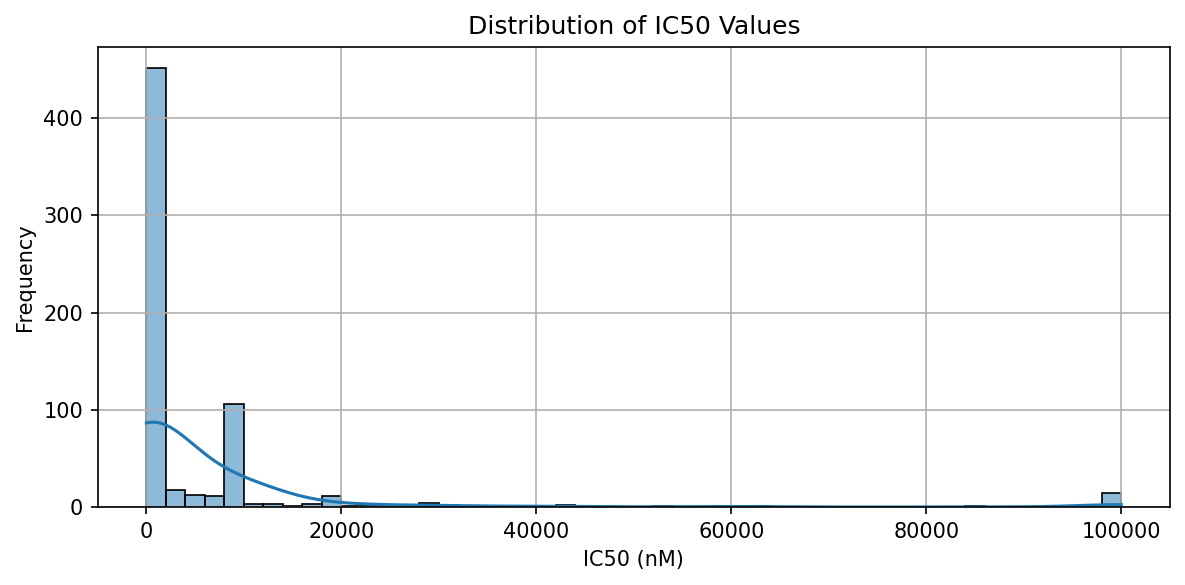

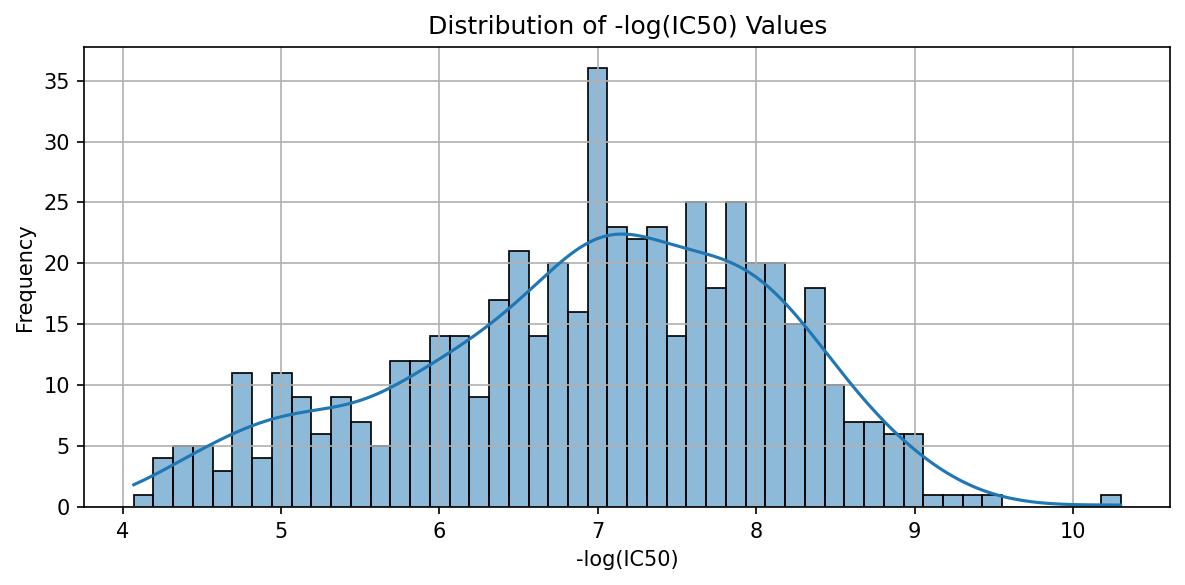

In [6]:
#The distribution of IC50 values
plt.figure(figsize=(8, 4), dpi=150)
sns.histplot(df_filtered['Standard Value'], bins=50, kde=True)
plt.title('Distribution of IC50 Values')
plt.xlabel('IC50 (nM)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


#The distribution of -log(IC50) values
plt.figure(figsize=(8, 4), dpi=150)
sns.histplot(df_filtered['pChEMBL Value'], bins=50, kde=True)
plt.title('Distribution of -log(IC50) Values')
plt.xlabel('-log(IC50)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


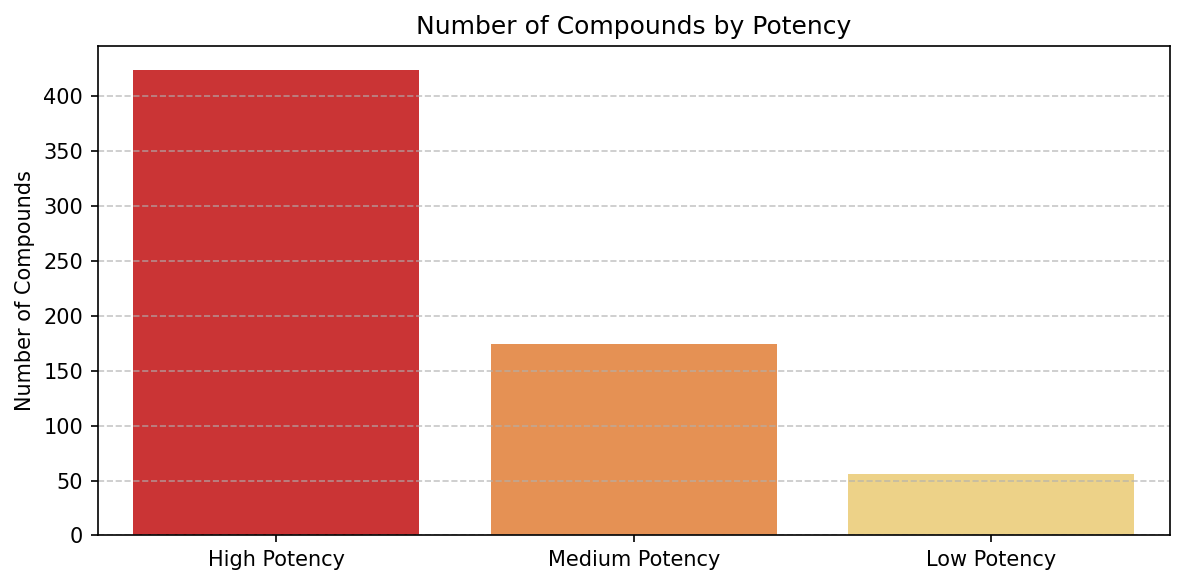

In [7]:
#Bar plots of Inhibitor categories
def categorize_potency(value):
    if value <= 1000:
        return 'High Potency'
    elif 1000 < value <= 10000:
        return 'Medium Potency'
    else:
        return 'Low Potency'

df_filtered['Potency'] = df_filtered['Standard Value'].apply(categorize_potency) #categorize the potency of the inhibitors
potency_counts = df_filtered['Potency'].value_counts() #count the occurance of each potency

# Step 4: Create a bar plot of the counts
plt.figure(figsize=(8, 4), dpi=150)
sns.barplot(x=potency_counts.index, y=potency_counts.values, palette='YlOrRd_r', hue=potency_counts.index)
plt.title('Number of Compounds by Potency')
plt.xlabel('')
plt.ylabel('Number of Compounds')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

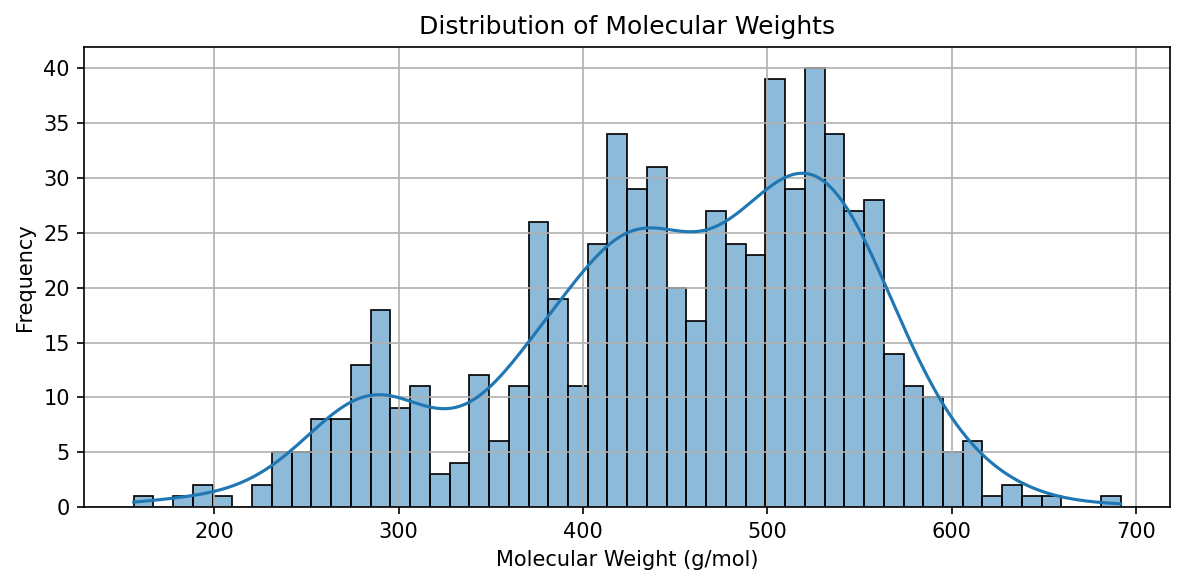

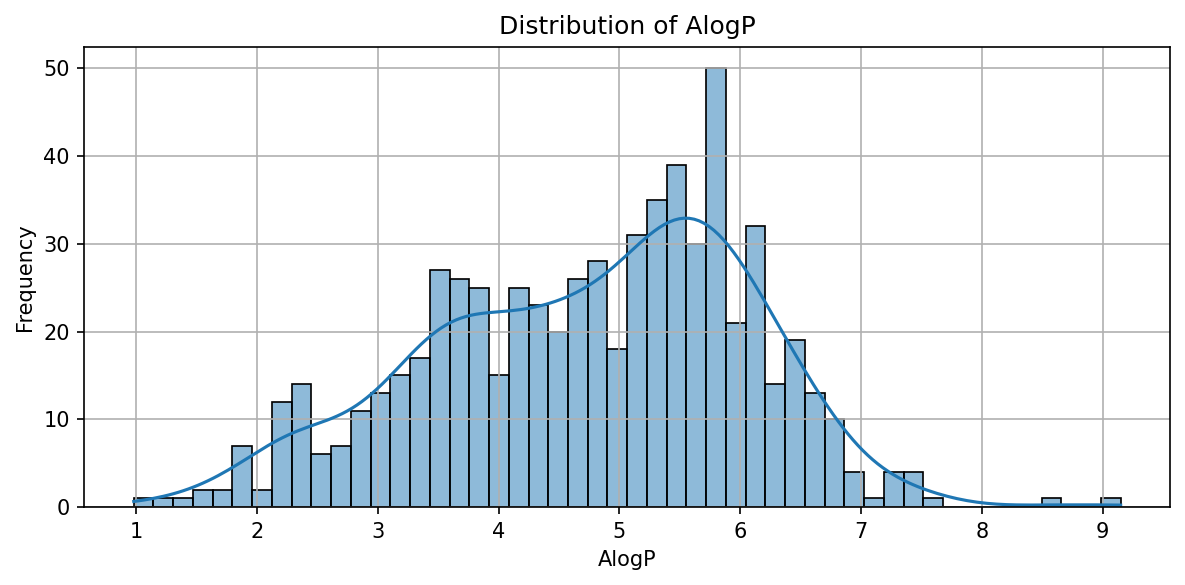

In [9]:
#Distribution of molecular weights
plt.figure(figsize=(8, 4), dpi=150)
sns.histplot(df_filtered['Molecular Weight'], bins=50, kde=True)
plt.title('Distribution of Molecular Weights')
plt.xlabel('Molecular Weight (g/mol)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

#Distribution of AlogP
plt.figure(figsize=(8, 4), dpi=150)
sns.histplot(df_filtered['AlogP'], bins=50, kde=True)
plt.title('Distribution of AlogP')
plt.xlabel('AlogP')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


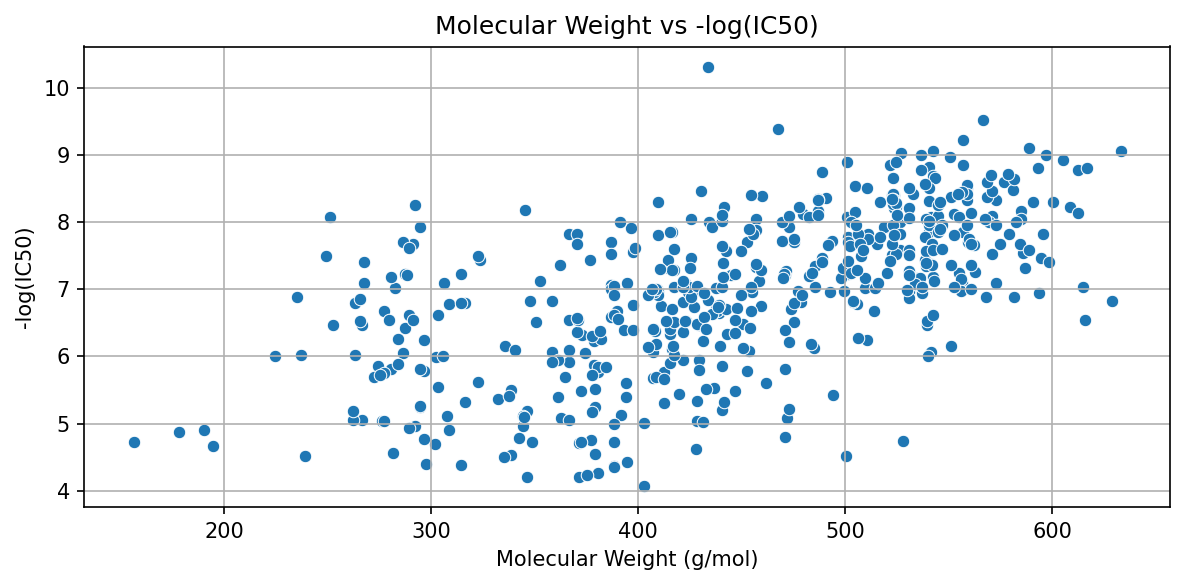

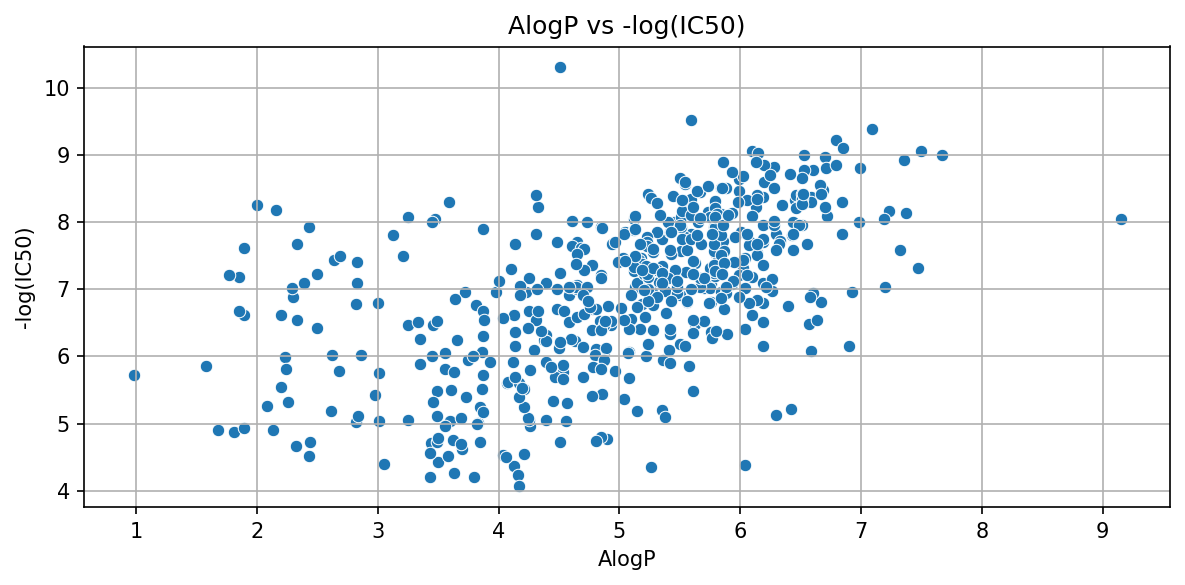

In [10]:
#Scatter plot of Molecular Weight vs -log(IC50) values
plt.figure(figsize=(8, 4), dpi=150)
sns.scatterplot(x='Molecular Weight', y='pChEMBL Value', data=df_filtered)
plt.title('Molecular Weight vs -log(IC50)')
plt.xlabel('Molecular Weight (g/mol)')
plt.ylabel('-log(IC50)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Scatter plot of AlogP vs -log(IC50) values
plt.figure(figsize=(8, 4), dpi=150)
sns.scatterplot(x='AlogP', y='pChEMBL Value', data=df_filtered)
plt.title('AlogP vs -log(IC50)')
plt.xlabel('AlogP')
plt.ylabel('-log(IC50)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Standardize Data

In [14]:
#Select the columns for standardization
columns_to_standardize = ['Molecular Weight', 'AlogP', 'Standard Value', 'pChEMBL Value','Ligand Efficiency LE','Ligand Efficiency LLE','Ligand Efficiency SEI']

scaler = StandardScaler()
#Fit the scaler and transform the selected columns
for col in columns_to_standardize:
    standardized_col = f"{col}_standardized"  # Create a new column name
    df_filtered[standardized_col] = scaler.fit_transform(df_filtered[[col]])

#Save dataset
df_filtered.to_csv('TRPM8-homosapien-compounds-activities-processed.csv', index=False)